In [ ]:
#from google.colab import drive
#drive.mount('/content/drive',force_remount=True)

# Autoencoder inpainting
Made with assistance from https://wandb.ai/site/articles/introduction-to-image-inpainting-with-deep-learning

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import os
import cv2
import numpy as np
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pickle

2023-05-29 07:09:52.156804: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load Data

In [2]:
#image_directory = '/content/drive/MyDrive/Grad School/ASL-Data/data/train/matching_images'
image_directory = './data/train/matching_images'

# Get the list of image file names
image_files = os.listdir(image_directory)

# Load the images and assign labels manually
x_train = []
y_train = []

for filename in image_files:
    # Load the image
    image_path = os.path.join(image_directory, filename)
    image = keras.preprocessing.image.load_img(image_path, target_size=(256, 256))
    image_array = keras.preprocessing.image.img_to_array(image).astype('uint8')  # Convert to uint8
    
    # Add the image to the training data
    x_train.append(image_array)
    
    # Assign a label based on the filename or any other criteria
    # Modify this part according to your labeling requirements
    y_train.append(filename[0])

# Convert the lists to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print('y_train shape:', y_train.shape)


x_train shape: (504, 256, 256, 3)
504 train samples
y_train shape: (504,)


In [3]:
x_train = np.concatenate([x_train, x_train, x_train, x_train], axis=0)
y_train = np.concatenate([y_train, y_train, y_train,y_train], axis=0)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print('y_train shape:', y_train.shape)

x_train shape: (2016, 256, 256, 3)
2016 train samples
y_train shape: (2016,)


In [4]:
#image_directory = '/content/drive/MyDrive/Grad School/ASL-Data/data/test/matching_images'
image_directory = './data/test/matching_images'

# Get the list of image file names
image_files = os.listdir(image_directory)

# Load the images and assign labels manually
x_test = []
y_test = []

for filename in image_files:
    # Load the image
    image_path = os.path.join(image_directory, filename)
    image = keras.preprocessing.image.load_img(image_path, target_size=(256, 256))
    image_array = keras.preprocessing.image.img_to_array(image).astype('uint8')  # Convert to uint8
    
    # Add the image to the training data
    x_test.append(image_array)
    
    # Assign a label based on the filename or any other criteria
    # Modify this part according to your labeling requirements
    y_test.append(filename[0])

# Convert the lists to numpy arrays
x_test = np.array(x_test)
y_test = np.array(y_test)

print('x_test shape:', x_test.shape)
print(x_test.shape[0], 'test samples')
print('y_test shape:', y_test.shape)


x_test shape: (72, 256, 256, 3)
72 test samples
y_test shape: (72,)


## Create Data Generators for Batch Training

In [6]:
## Ref: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.
class createAugment(keras.utils.Sequence):
  #'Generates data for Keras'
    def __init__(self, X, y, batch_size=32, dim=(256, 256), n_channels=3, shuffle=True):
        #'Initialization'
        self.batch_size = batch_size 
        self.X = X 
        self.y = y
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle

        self.on_epoch_end()

    def __len__(self):
        #'Denotes the number of batches per epoch'
        return int(np.floor(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        return self.__data_generation(indexes)

    def on_epoch_end(self):
        #'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.X))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, idxs):
        # X_batch is a matrix of masked images used as input
        X_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Masked image
        # y_batch is a matrix of original images used for computing error from reconstructed image
        y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Original image

        ## Iterate through random indexes
        for i, idx in enumerate(idxs):
            image_copy = self.X[idx].copy()

            ## Get mask associated to that image
            masked_image = self.__createMask(image_copy)

            X_batch[i,] = masked_image/255
            y_batch[i] = self.y[idx]/255

        return X_batch, y_batch

    def __createMask(self, img):
        ## Prepare masking matrix
        mask = np.full((256,256,3), 255, np.uint8)
        for _ in range(np.random.randint(1, 10)):
            # Get random x locations to start line
            x1, x2 = np.random.randint(1, 256), np.random.randint(1, 256)
            # Get random y locations to start line
            y1, y2 = np.random.randint(1, 256), np.random.randint(1, 256)
            # Get random thickness of the line drawn
            thickness = np.random.randint(8, 16)
            # Draw black line on the white mask
            cv2.line(mask,(x1,y1),(x2,y2),(1,1,1),thickness)

        # Perforn bitwise and operation to mak the image
        masked_image = cv2.bitwise_and(img, mask)

        return masked_image

In [7]:
## Prepare training and testing mask-image pair generator
traingen = createAugment(x_train, x_train)
testgen = createAugment(x_test, x_test, shuffle=False)

## Display Corrupted and Uncorrupted Images

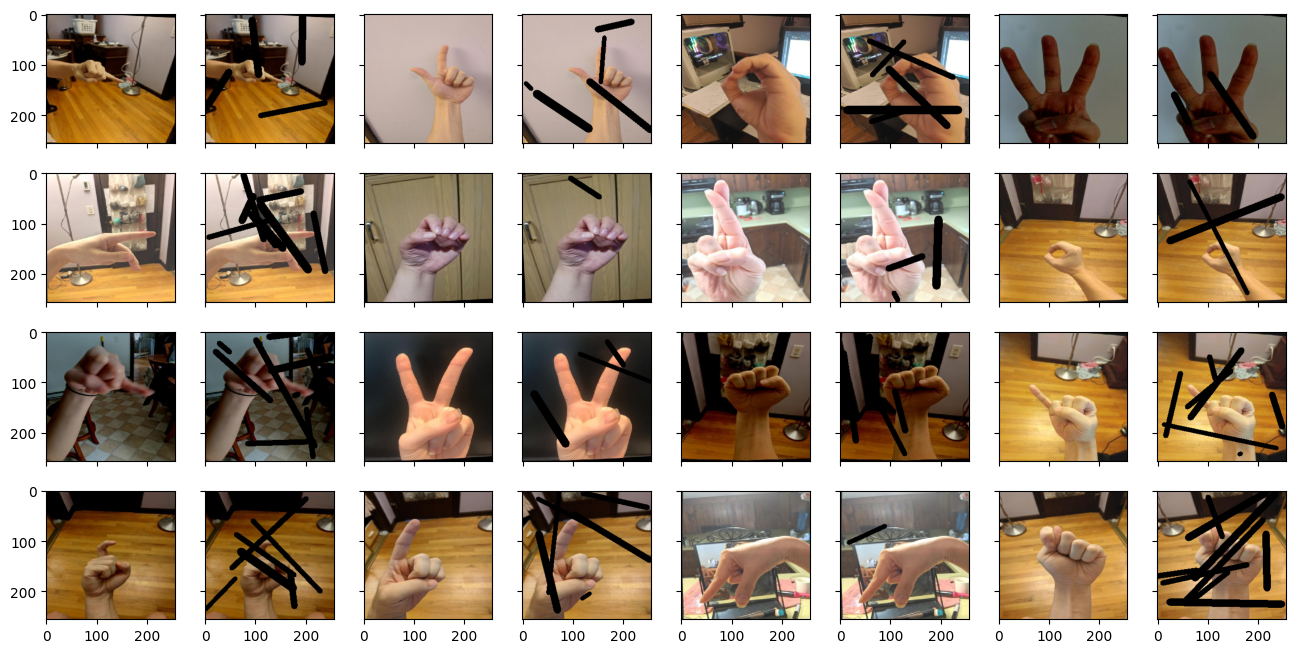

In [8]:
## Examples
sample_idx = 2 ## Change this to see different batches

sample_masks, sample_labels = traingen[sample_idx]
sample_images = [None]*(len(sample_masks)+len(sample_labels))
sample_images[::2] = sample_labels
sample_images[1::2] = sample_masks

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image in zip(grid, sample_images):
    ax.imshow(image)

plt.show()

## Define Metric for Model Evaluation
Dice coefficient is a metric commonly used to evaluate the accuracy and quality of the predicted masks compared to the ground truth masks. A higher Dice coefficient indicates better similarity and overlap between the predicted and ground truth masks, indicating better performance.

The Dice coefficient is calculated as follows: Dice_coef = (2 * |A ∩ B|) / (|A| + |B|)
- |A ∩ B| represents the intersection of images A and B, i.e., the number of common pixels between the two images.
- |A| represents the number pixels in image A.
- |B| represents the number pixels in image B.

In [9]:
## For more information into formulation: https://www.youtube.com/watch?v=AZr64OxshLo
## Metric
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

## Define Model Architecture
The structure is based on a UNET-like model and is an autoencoder(source)
- Four downsample blocks and four upsample blocks.
- Each downsample block consists of two consecutive convolutional layers and a max pooling layer.
- Each upsample block consists of two consecutive convolutional layers and a transposed convolutional layer. The upsampled feature maps are concatenated with the corresponding feature maps from the downsample path (shared_layer) along the channel axis.
- The final upsample block does not have a pooling layer after the convolutional layers.
- The model ends with a 2D convolutional layer with 3 filters (for RGB channels) and sigmoid activation function.

In [10]:
class InpaintingModel:
    '''
    Build UNET-like model for image inpainting task.
    '''
    def prepare_model(self, input_size=(256, 256, 3)):
        inputs = keras.layers.Input(input_size)

        conv1, pool1 = self.__ConvBlock(32, (3, 3), (2, 2), 'relu', 'same', inputs)
        conv2, pool2 = self.__ConvBlock(64, (3, 3), (2, 2), 'relu', 'same', pool1)
        conv3, pool3 = self.__ConvBlock(128, (3, 3), (2, 2), 'relu', 'same', pool2)
        conv4, pool4 = self.__ConvBlock(256, (3, 3), (2, 2), 'relu', 'same', pool3)

        conv5, up6 = self.__UpConvBlock(512, 256, (3, 3), (2, 2), (2, 2), 'relu', 'same', pool4, conv4)
        conv6, up7 = self.__UpConvBlock(256, 128, (3, 3), (2, 2), (2, 2), 'relu', 'same', up6, conv3)
        conv7, up8 = self.__UpConvBlock(128, 64, (3, 3), (2, 2), (2, 2), 'relu', 'same', up7, conv2)
        conv8, up9 = self.__UpConvBlock(64, 32, (3, 3), (2, 2), (2, 2), 'relu', 'same', up8, conv1)

        conv9 = self.__ConvBlock(32, (3, 3), (2, 2), 'relu', 'same', up9, False)

        outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv9)

        return keras.models.Model(inputs=[inputs], outputs=[outputs])

    def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
        conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(
            connecting_layer)
        conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(
            conv)
        if pool_layer:
            pool = keras.layers.MaxPooling2D(pool_size)(conv)
            return conv, pool
        else:
            return conv

    def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding,
                      connecting_layer, shared_layer):
        conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(
            connecting_layer)
        conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(
            conv)
        up = keras.layers.Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride,
                                          padding=padding)(conv)
        up = keras.layers.concatenate([up, shared_layer], axis=3)

        return conv, up

In [11]:
keras.backend.clear_session()
model = InpaintingModel().prepare_model()
model.compile(optimizer='adam', loss='mse', metrics=[dice_coef])

2023-05-29 07:10:37.003634: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-29 07:10:37.010022: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-29 07:10:37.010400: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-29 07:10:37.011477: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-29 07:10:37.011797: I tensorflow/compile

## Train model

In [12]:
history = model.fit(traingen, 
          validation_data=testgen, 
          epochs=50, 
          steps_per_epoch=len(traingen), 
          validation_steps=len(testgen),
          use_multiprocessing=True)

Epoch 1/50


2023-05-29 07:10:42.097851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-29 07:10:46.414243: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-29 07:10:51.088842: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x11f16a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-29 07:10:51.088886: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2023-05-29 07:10:51.111600: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-29 07:10:51.24

63/63 [==============================] - ETA: 0s - loss: 0.0234 - dice_coef: 0.5551

2023-05-29 07:11:57.623831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


63/63 [==============================] - 84s 1s/step - loss: 0.0234 - dice_coef: 0.5551 - val_loss: 0.0049 - val_dice_coef: 0.5649
Epoch 2/50
63/63 [==============================] - 91s 1s/step - loss: 0.0042 - dice_coef: 0.5866 - val_loss: 0.0033 - val_dice_coef: 0.5564
Epoch 3/50
63/63 [==============================] - 92s 1s/step - loss: 0.0030 - dice_coef: 0.5902 - val_loss: 0.0026 - val_dice_coef: 0.5546
Epoch 4/50
63/63 [==============================] - 92s 1s/step - loss: 0.0023 - dice_coef: 0.5916 - val_loss: 0.0021 - val_dice_coef: 0.5547
Epoch 5/50
63/63 [==============================] - 97s 2s/step - loss: 0.0019 - dice_coef: 0.5930 - val_loss: 0.0018 - val_dice_coef: 0.5574
Epoch 6/50
63/63 [==============================] - 88s 1s/step - loss: 0.0015 - dice_coef: 0.5933 - val_loss: 0.0015 - val_dice_coef: 0.5631
Epoch 7/50
63/63 [==============================] - 93s 1s/step - loss: 0.0014 - dice_coef: 0.5939 - val_loss: 0.0016 - val_dice_coef: 0.5580
Epoch 8/50
63/63 

## Save Model and Training history

In [13]:
with open('AE_model_256.pkl','wb') as output:
    pickle.dump(model,output)

In [14]:
with open('AE_model_hist_256.pkl', 'wb') as output:
    pickle.dump(history, output)

## Inpaint Images and Display Output

1/1 [==============================] - 0s 17ms/step


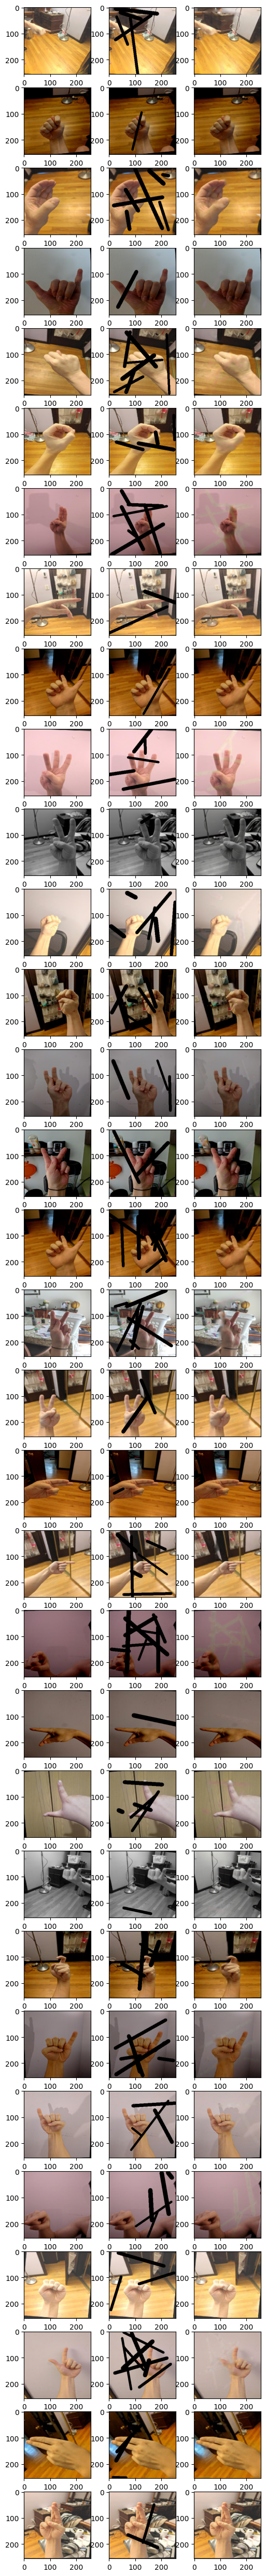

In [15]:
## Examples
rows = 32
sample_idx = 2
sample_images, sample_labels = traingen[sample_idx]

fig, axs = plt.subplots(nrows=rows, ncols=3, figsize=(6, 2*rows))

for i in range(32):
    impainted_image = model.predict(sample_images[i].reshape((1,)+sample_images[i].shape))
    axs[i][0].imshow(sample_labels[i])
    axs[i][1].imshow(sample_images[i])
    axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))

plt.show()